In [1]:
from pyM2aia import M2aiaImageHelper
from ctypes import CDLL
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch import nn
from torch import optim
import SimpleITK as sitk
from pathlib import Path
import sys

lib = CDLL('libM2aiaCoreIO.so')
image = "ew_section3_pos.imzML"
params = "m2PeakPicking.txt"

intensity_count = 0
I = None
pixel = None
with M2aiaImageHelper(lib, image, params) as helper:
    gen = helper.SpectrumIterator()
    pixel = next(gen)[2]
    intensity_count = len(pixel)
    I = helper.GetImage(1000, 0.54, np.float32)
A = sitk.GetArrayFromImage(I)
x_size = A.shape[1]
y_size = A.shape[2]
print(A.shape)
print(I.GetSize())
print(intensity_count)  

[Sun Nov 21 19:11:53 2021 
1.929] baseline-correction None
[1.929] baseline-correction-hw 50
[1.929] smoothing None
[1.929] smoothing-hw 2
[1.929] normalization None
[1.929] pooling Maximum
[1.929] tolerance 0
[1.929] threads 24
[1.929] Start reading imzML...
[1.929] ImzMLSpectrumImage created!
[1.929] Parsing imzML started ...
[2.111] SciLs 3D tag found
[2.112] 	1 unique z positions found:
0, [2.112] Parsing imzML: 0.182507s
[2.112] Initialize placeholder images and spectra started ...
[2.121] Initialize placeholder images and spectra: 0.0082368s
[2.121] Load external data started ...
[2.123] Load external data: 0.000982282s
[2.123] Continuous Profile
[2.125] Initialize image started ...
[4.256] Initialize image: 0.154939s
[4.363] ImzMLSpectrumImage destroyed!
(1, 169, 224)
(224, 169, 1)
29693


In [2]:
# Welford's online algorithm for calculating mean and variance

# For a new value newValue, compute the new count, new mean, the new M2.
# mean accumulates the mean of the entire dataset
# M2 aggregates the squared distance from the mean
# count aggregates the number of samples seen so far
def update(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2
    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float("nan")
    else:
        (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
        return (mean, variance, sampleVariance)

In [3]:
aggregate = [0, np.zeros((intensity_count)), np.zeros((intensity_count))]
with M2aiaImageHelper(lib, image, params) as helper:
    gen = helper.SpectrumIterator()
    for data in gen:
        i, xs, ys = data
        aggregate = update(aggregate, ys)
im_mean, im_variance, im_sampleVariance = finalize(aggregate)
im_stddev = np.sqrt(im_sampleVariance)
print(im_mean, im_variance, im_sampleVariance)

[4.373] baseline-correction None
[4.373] baseline-correction-hw 50
[4.373] smoothing None
[4.373] smoothing-hw 2
[4.373] normalization None
[4.373] pooling Maximum
[4.373] tolerance 0
[4.373] threads 24
[4.373] Start reading imzML...
[4.373] ImzMLSpectrumImage created!
[4.373] Parsing imzML started ...
[4.558] SciLs 3D tag found
[4.559] 	1 unique z positions found:
0, [4.559] Parsing imzML: 0.183243s
[4.559] Initialize placeholder images and spectra started ...
[4.569] Initialize placeholder images and spectra: 0.00835031s
[4.569] Load external data started ...
[4.570] Load external data: 0.000826114s
[4.570] Continuous Profile
[4.572] Initialize image started ...
[6.693] Initialize image: 0.161646s
[10.431] ImzMLSpectrumImage destroyed!
[0.         0.09790998 0.09859938 ... 0.04207615 0.04146861 0.        ] [0.         0.00735758 0.00790624 ... 0.00170585 0.00177776 0.        ] [0.         0.00735784 0.00790652 ... 0.00170591 0.00177782 0.        ]


In [4]:
print(f"torch cuda version: {torch.version.cuda}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch cuda version: 11.3
cuda


In [5]:
# test_mean = np.arange(-1, 1, 0.1)
# test_logvar = np.arange(-1, 1, 0.1)
# test_mean, test_logvar = np.meshgrid(test_mean, test_logvar)
# vals = -0.5*(1 + test_logvar - np.power(test_mean, 2) - np.exp(test_logvar))
# plt.contourf(test_mean, test_logvar, vals)
# plt.colorbar()
# plt.xlabel("mean")
# plt.ylabel("logvar")
# print(np.exp(0))

In [6]:
latent_size = 16
class Vae(nn.Module):
    def __init__(self):
        super(Vae, self).__init__()

        # encoder
        self.enc1 = nn.Linear(intensity_count, intensity_count//8)
        self.enc2 = nn.Linear(intensity_count//8, intensity_count//64)
        self.enc3 = nn.Linear(intensity_count//64, latent_size)

        # decoder
        self.dec1 = nn.Linear(latent_size, intensity_count//64)
        self.dec2 = nn.Linear(intensity_count//64, intensity_count//8)
        self.dec3 = nn.Linear(intensity_count//8, intensity_count)

    def encode(self, x):
        x = torch.tanh(self.enc1(x))
        x = torch.tanh(self.enc2(x))
        x = self.enc3(x)
        return x

    def decode(self, x):
        x = torch.tanh(self.dec1(x))
        x = torch.tanh(self.dec2(x))
        x = self.dec3(x)
        return x

    def forward(self, x):
        # encoding
        x = self.encode(x)

        # decoding
        x = self.decode(x)
        return x

def train(batch):
    optimizer.zero_grad()
    reconstruction = model(batch)
    loss = loss_function(reconstruction, batch)
    loss.backward()
    optimizer.step()
    return loss

In [7]:
model = Vae()
if torch.cuda.device_count() > 1:
    print(torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)
model.to(device)
model_params = Path("/home/dbogacz/Development/pyM2aia/tests/model_params.pt")
print(f"model_params already exist? {model_params.is_file()}")
if model_params.is_file():
    model.load_state_dict(torch.load(model_params))
print(f"model on cuda? {next(model.parameters()).is_cuda}")
optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss()

2 GPUs
model_params already exist? False
model on cuda? True


In [8]:
iterations = 10000
total_loss = []
kld_loss = []
rec_loss = []
with M2aiaImageHelper(lib, image, params) as helper:

    # training
    batch_iter = helper.SpectrumRandomBatchIterator(512)
    for i in range(iterations):
        batch = next(batch_iter)
        batch -= im_mean # data zero centering
        batch /= (im_stddev + 1e-10) # data normalization
        batch = torch.from_numpy(batch).to(device)
        loss = train(batch)
        
        # visualization
        total_loss.append(loss.item())

        if i % (iterations//10) == 0:
            print(f"{i:6d}: loss: {loss.item():3.4f}")
    
    # save learned model parameters
    # torch.save(model.state_dict(), "/home/dbogacz/Development/pyM2aia/tests/model_params.pt")

    # save encoded image to .nrrd file
    imgData = np.zeros((1, x_size, y_size, latent_size))
    gen = helper.SpectrumIterator()
    for data in gen:
        id, xs, ys = data
        x, y, z = helper.GetPixelPosition(id)
        ys -= im_mean # data zero centering
        ys /= (im_stddev + 1e-10) # data normalization
        ys = torch.unsqueeze(torch.from_numpy(ys).to(device), 0)
        with torch.no_grad():
            latent_vector = model.module.encode(ys)
        imgData[z, y, x, :] = latent_vector.cpu().numpy()
    im = sitk.GetImageFromArray(imgData)
    sitk.WriteImage(im, "/home/dbogacz/Development/pyM2aia/tests/worm_section3.nrrd")

[13.643] baseline-correction None
[13.643] baseline-correction-hw 50
[13.643] smoothing None
[13.643] smoothing-hw 2
[13.643] normalization None
[13.643] pooling Maximum
[13.643] tolerance 0
[13.643] threads 24
[13.644] Start reading imzML...
[13.644] ImzMLSpectrumImage created!
[13.644] Parsing imzML started ...
[13.828] SciLs 3D tag found
[13.828] 	1 unique z positions found:
0, [13.829] Parsing imzML: 0.18282s
[13.829] Initialize placeholder images and spectra started ...
[13.839] Initialize placeholder images and spectra: 0.00831364s
[13.839] Load external data started ...
[13.840] Load external data: 0.000798229s
[13.840] Continuous Profile
[13.842] Initialize image started ...
[15.929] Initialize image: 0.15938s
     0: rec_loss: 16384340.0000 | kld_loss: 138.5375
  1000: rec_loss: 12695333.0000 | kld_loss: 18167.3301
  2000: rec_loss: 8931806.0000 | kld_loss: 30720.6914
  3000: rec_loss: 9488076.0000 | kld_loss: 29810.6777
  4000: rec_loss: 9359200.0000 | kld_loss: 30277.3613
  

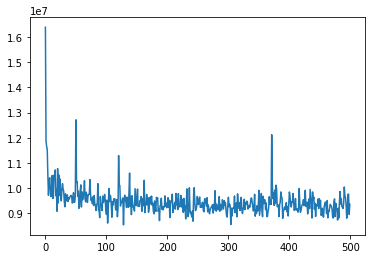

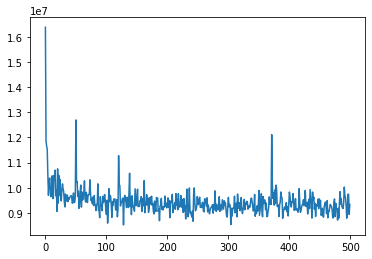

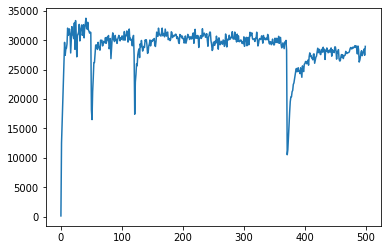

In [9]:
plt.figure(1)
plt.plot(total_loss[::20])

In [10]:
# eval on another imzML file
image = "ew_section1_pos.imzML"

aggregate = [0, np.zeros((intensity_count)), np.zeros((intensity_count))]
with M2aiaImageHelper(lib, image, params) as helper:
    gen = helper.SpectrumIterator()
    for data in gen:
        i, xs, ys = data
        aggregate = update(aggregate, ys)
    im_mean, im_variance, im_sampleVariance = finalize(aggregate)
    im_stddev = np.sqrt(im_sampleVariance)

    I = helper.GetImage(1000, 0.54, np.float32)
    A = sitk.GetArrayFromImage(I)
    x_size = A.shape[1]
    y_size = A.shape[2]

    imgData = np.zeros((1, x_size, y_size, latent_size))
    gen = helper.SpectrumIterator()
    for data in gen:
        id, xs, ys = data
        x, y, z = helper.GetPixelPosition(id)
        ys -= im_mean # data zero centering
        ys /= (im_stddev + 1e-10) # data normalization
        ys = torch.unsqueeze(torch.from_numpy(ys).to(device), 0)
        with torch.no_grad():
            latent_vector = model.module.encode(ys)
        imgData[z, y, x, :] = latent_vector.cpu().numpy()
    im = sitk.GetImageFromArray(imgData)
    sitk.WriteImage(im, "/home/dbogacz/Development/pyM2aia/tests/worm_section1.nrrd")

[1893.280] baseline-correction None
[1893.280] baseline-correction-hw 50
[1893.280] smoothing None
[1893.280] smoothing-hw 2
[1893.280] normalization None
[1893.280] pooling Maximum
[1893.280] tolerance 0
[1893.280] threads 24
[1893.280] Start reading imzML...
[1893.280] ImzMLSpectrumImage created!
[1893.280] Parsing imzML started ...
[1893.387] SciLs 3D tag found
[1893.387] 	1 unique z positions found:
0, [1893.387] Parsing imzML: 0.106653s
[1893.387] Initialize placeholder images and spectra started ...
[1893.397] Initialize placeholder images and spectra: 0.00857193s
[1893.397] Load external data started ...
[1893.398] Load external data: 0.000285806s
[1893.398] Continuous Profile
[1893.399] Initialize image started ...
[1894.514] Initialize image: 0.118509s
[1913.454] ImzMLSpectrumImage destroyed!
